In [5]:
#pip install nltk transformers pyLDAvis spacy gensim
#python -m spacy download en_core_web_lg
#python -m spacy download en_core_web_sm

In [6]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

In [7]:
import spacy
import requests
import string
from gensim.models import TfidfModel
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

In [11]:
def get_wikipedia_content(title, lang="en"):
    # Base URL per l'API di Wikipedia
    base_url = f"https://{lang}.wikipedia.org/w/api.php"

    # Parametri per la richiesta API
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    # Extract content
    pages = data["query"]["pages"]
    for page_id, page_data in pages.items():
        return page_data['extract']

    return None

In [12]:
title = "Italy"
content = get_wikipedia_content(title)
print(content)

Italy, officially the Italian Republic, is a country in Southern and Western Europe. It is located on a peninsula that extends into the middle of the Mediterranean Sea, with the Alps on its northern land border, as well as several islands, notably Sicily and Sardinia. Italy shares its borders with France, Switzerland, Austria, Slovenia and two enclaves: Vatican City and San Marino. Its territory also includes Campione (an exclave surrounded by Switzerland) and the Pelagie Islands (an archipelago in the African Plate). It is the tenth-largest country by land area in the European continent, covering an area of 301,340 km2 (116,350 sq mi), and the third-most populous member state of the European Union, with a population of nearly 60 million. Its capital and largest city is Rome.
In antiquity, the Italian peninsula was home to numerous peoples; the Latin city of Rome in central Italy, founded as a Kingdom, became a Republic that conquered the Mediterranean world and ruled it for centuries 

In [17]:
# 1. Initialization: download necessary resources and load models
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# For NER, spacy is used. Ensure you've downloaded the English model 'en_core_web_sm'
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Florenzio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Florenzio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def preprocess_text(text):
    # 2. Lowercasing
    text = text.lower()

    # 3. Tokenize sentences and words
    sentences = sent_tokenize(text)
    tokens = [word_tokenize(sentence) for sentence in sentences]

    # 4. Remove stop words and punctuations
    tokens = [[word for word in sentence if word not in stop_words and word not in string.punctuation]
              for sentence in tokens]

    return tokens

def create_bag_of_words(tokens):
    # 5. Create a Bag of Words using Gensim
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(text) for text in tokens]
    return dictionary, corpus

def compute_tfidf(corpus):
    # 6. Compute TF-IDF
    tfidf = TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    return corpus_tfidf

def top_n_words_from_tfidf(corpus_tfidf, dictionary, n=10):
    # Flatten the corpus_tfidf and sort by the tf-idf value
    sorted_tfidf = sorted([(dictionary[id], value) for doc in corpus_tfidf for id, value in doc],
                          key=lambda x: x[1], reverse=True)

    # Pick top n words
    top_words = [word for word, value in sorted_tfidf[:n]]
    return top_words

def perform_ner(text):
    # 7. Named Entity Recognition (NER)
    doc = nlp(text)
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]
    return named_entities

In [19]:
# Example usage:
tokens = preprocess_text(content)
dictionary, corpus = create_bag_of_words(tokens)
corpus_tfidf = compute_tfidf(corpus)
entities = perform_ner(content)
top_words = top_n_words_from_tfidf(corpus_tfidf, dictionary, 10)

In [20]:
print("Tokens:", tokens)
print("Bag of Words:", corpus)
print("Named Entities:", entities)

Tokens: [['italy', 'officially', 'italian', 'republic', 'country', 'southern', 'western', 'europe'], ['located', 'peninsula', 'extends', 'middle', 'mediterranean', 'sea', 'alps', 'northern', 'land', 'border', 'well', 'several', 'islands', 'notably', 'sicily', 'sardinia'], ['italy', 'shares', 'borders', 'france', 'switzerland', 'austria', 'slovenia', 'two', 'enclaves', 'vatican', 'city', 'san', 'marino'], ['territory', 'also', 'includes', 'campione', 'exclave', 'surrounded', 'switzerland', 'pelagie', 'islands', 'archipelago', 'african', 'plate'], ['tenth-largest', 'country', 'land', 'area', 'european', 'continent', 'covering', 'area', '301,340', 'km2', '116,350', 'sq', 'mi', 'third-most', 'populous', 'member', 'state', 'european', 'union', 'population', 'nearly', '60', 'million'], ['capital', 'largest', 'city', 'rome'], ['antiquity', 'italian', 'peninsula', 'home', 'numerous', 'peoples', 'latin', 'city', 'rome', 'central', 'italy', 'founded', 'kingdom', 'became', 'republic', 'conquered'

In [21]:
# Assuming 'tokens' is the list of tokenized documents, as defined in the previous code.
# tokens = preprocess_text(your_text)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

# Train the LDA model
num_topics = 1  # You can adjust this based on your needs
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [24]:
def extract_topic_from_text(text, num_topics=5, topn=3):
    tokens = preprocess_text(text)

    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(t) for t in tokens]

    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Get the dominant topic for the given text
    dominant_topic = sorted(lda_model[corpus[0]], key=lambda x: x[1], reverse=True)[0]
    topic_id = dominant_topic[0]

    # Get top `topn` words from this topic
    topic_words = lda_model.show_topic(topic_id, topn=topn)
    dominant_words = [word for word, _ in topic_words]

    # Return the most dominant word or phrase
    return ' '.join(dominant_words)

In [25]:
# Example usage:
topic = extract_topic_from_text(content)

In [26]:
top_words

['factbook',
 '==',
 'navy',
 'provincial',
 'sport',
 'species',
 'gardens',
 'festivities',
 'composers',
 'philosophy']

In [27]:
topic

'italian italy world'

In [28]:
nltk.download('vader_lexicon')

def analyze_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)

    return sentiment_scores

# Example usage:
text = content

sentiment = analyze_sentiment_vader(text)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Florenzio\AppData\Roaming\nltk_data...


In [29]:
score = sentiment['neg'] * (-1) + sentiment['neu'] * 0 + sentiment['pos'] * 1

In [30]:
score

0.042

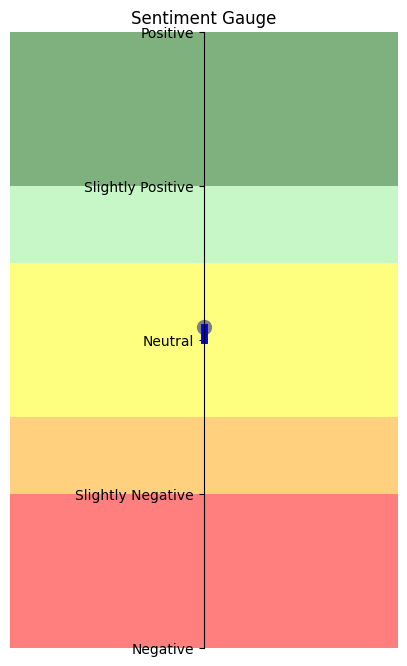

In [31]:
def plot_sentiment(sentiment_value):
    # Create a vertical sentiment gauge
    fig, ax = plt.subplots(figsize=(5, 8))

    # Set the axis limits and labels
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1, 1)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xticks([])
    ax.set_yticklabels(["Negative", "Slightly Negative", "Neutral", "Slightly Positive", "Positive"])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_position('center')

    # Plot the sentiment value
    ax.plot([0, 0], [0, sentiment_value], color="blue", lw=5, label="Sentiment")
    ax.scatter([0], [sentiment_value], color="blue", s=100)

    # Highlight the neutral area
    ax.axhspan(-1, -0.5, facecolor='red', alpha=0.5)
    ax.axhspan(-0.5, -0.25, facecolor='orange', alpha=0.5)
    ax.axhspan(-0.25, 0, facecolor='yellow', alpha=0.5)
    ax.axhspan(0, 0.25, facecolor='yellow', alpha=0.5)
    ax.axhspan(0.25, 0.5, facecolor='lightgreen', alpha=0.5)
    ax.axhspan(0.5, 1, facecolor='darkgreen', alpha=0.5)

    # Title
    ax.set_title("Sentiment Gauge")

    plt.show()

# Plot the sentiment
plot_sentiment(score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
